In [ ]:
# 📦 Cell 1 – setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from itertools import cycle

warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': [15, 20],
    'font.family': 'sans-serif',
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 9,
    'figure.titlesize': 16
})

print("Currency ETF analysis environment ready")

Currency ETF analysis environment ready


In [ ]:
# 📂 Cell 2 – load data
file_path = "/content/Currency_ETF_2017-mid_june25.csv"    # adjust as needed
raw_df = pd.read_csv(file_path)

price_rows = raw_df.iloc[5:].copy()
price_rows = price_rows[price_rows['Start Date'].notna()]

ticker_row = raw_df.iloc[2]
etf_cols = {ticker_row[col].split()[0]: col
            for col in raw_df.columns
            if isinstance(ticker_row[col], str) and 'Equity' in ticker_row[col]}

print(f"Found {len(etf_cols)} ETFs")

Found 30 ETFs


In [ ]:
# 🎨 Cell 3 – colour map
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ticker_colors = {tic: next(color_cycle) for tic in etf_cols}

In [ ]:
# 🔧 Cell 4 – helper functions
def get_series(ticker: str):
    """Return DataFrame with Date, Price, CumReturn, CumLogReturn."""
    if ticker not in etf_cols:
        return None

    price_col = raw_df.columns[raw_df.columns.get_loc(etf_cols[ticker]) + 3]
    out = price_rows[['Start Date', price_col]].copy()
    out.columns = ['Date', 'Price']
    out['Price'] = pd.to_numeric(out['Price'], errors='coerce')
    out = out.dropna()
    out['Date'] = pd.to_datetime(out['Date'])
    if out.empty:
        return None

    base_price = out['Price'].iloc[0]
    out['CumReturn']    = (out['Price'] / base_price) * 100          # arithmetic index
    out['LogReturn']    = np.log(out['Price']).diff().fillna(0)      # daily log return
    out['CumLogReturn'] = out['LogReturn'].cumsum()                  # natural-log scale
    return out


def build_dataset():
    data = {tic: get_series(tic) for tic in etf_cols}
    data = {k: v for k, v in data.items() if v is not None}
    start = max(df['Date'].min() for df in data.values())
    print(f"Common start date: {start:%Y-%m-%d}")
    for k in data:
        data[k] = data[k][data[k]['Date'] >= start].copy()
    return data

In [ ]:
# 📊 Cell 5 – process ETFs
etf_data = build_dataset()
print(f"Processed {len(etf_data)} tickers")

first_ticker = next(iter(etf_data))
etf_data[first_ticker].head()

Common start date: 2017-01-02
Processed 30 tickers


,Date,Price,CumReturn,LogReturn,CumLogReturn
5,2017-01-02,26.46,100.000000,0.000000,0.000000
6,2017-01-03,26.70,100.907029,0.009029,0.009029
7,2017-01-04,26.50,100.151172,-0.007519,0.001511
8,2017-01-05,26.22,99.092971,-0.010622,-0.009112
9,2017-01-06,26.41,99.811036,0.007220,-0.001891


In [ ]:
# 🗂️ Cell 6 – category definitions (auto-filtered)
base_categories = {
    "Major Developed Markets": ["UUP", "USDU", "FXE", "FXY", "FXF", "FXB", "FXC", "UDN", "HEFA", "FXA", "FXS", "FXSG"],
    "Emerging Markets": ["CEW", "HEEM", "HEZU", "IEMG", "EMLC"],
    "Hedged Currency ETFs": ["HEDJ", "HEFA", "HEWJ", "HEWW", "HEZU", "DBEF", "IHDG"],
    "Leveraged & Inverse": ["ULE", "YCL", "YCS"],
    "Precious Metals": ["OUNZ", "GLD"],
    "Other Equity/Fixed Income Related": ["USFR", "DGRW", "DLN", "DON"]
}

categories = {name: [t for t in tickers if t in etf_data]
              for name, tickers in base_categories.items()}
categories = {name: tickers for name, tickers in categories.items() if tickers}
print("Categories prepared")

Categories prepared


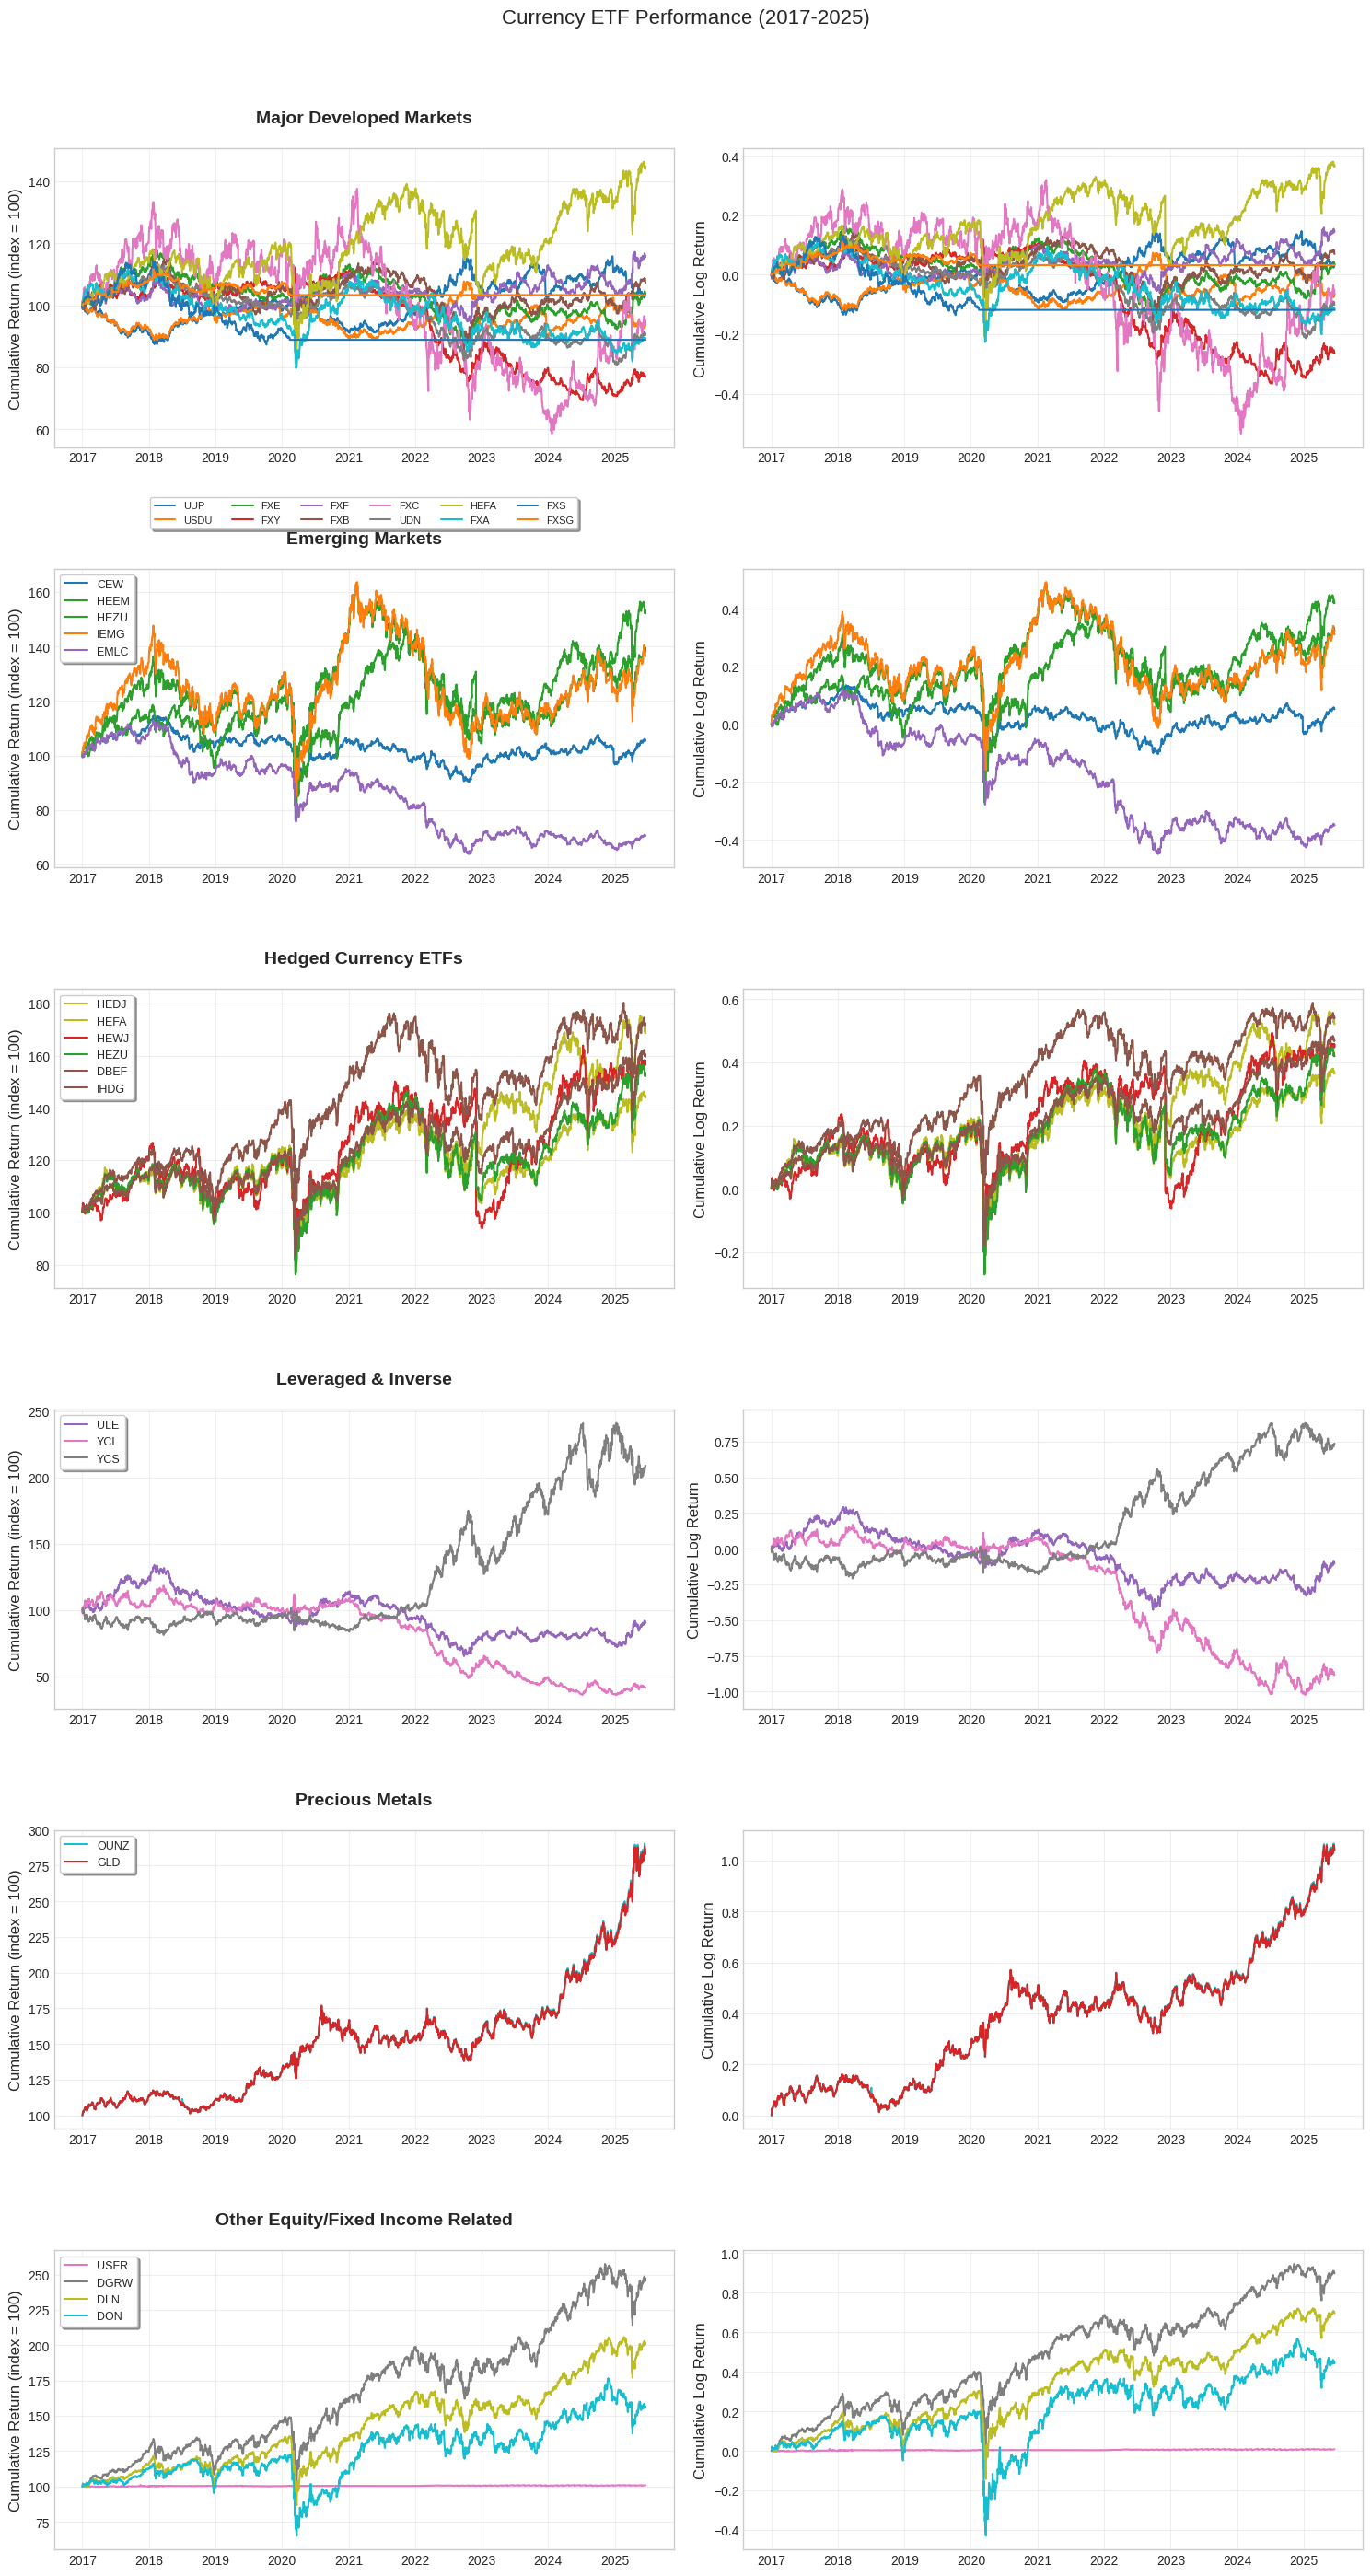

All 30 ETFs are covered by the categories.


In [ ]:
# 🖼️ Cell 7 – plot helpers (updated for Option 2)
def plot_group(ax_left, ax_right, group_name, tickers):
    for tic in tickers:
        df = etf_data[tic]
        ax_left.plot(df['Date'], df['CumReturn'],
                     label=tic, color=ticker_colors[tic], linewidth=1.5)
        ax_right.plot(df['Date'], df['CumLogReturn'],
                      label=tic, color=ticker_colors[tic], linewidth=1.5)

    ax_left.set_title(group_name, fontweight='bold', pad=20)
    ax_left.set_ylabel("Cumulative Return (index = 100)")
    ax_right.set_ylabel("Cumulative Log Return")

    # Place legend below the left plot for groups with many tickers
    if len(tickers) > 8:
        ncols = min(6, len(tickers))  # Max 6 columns to prevent overcrowding
        ax_left.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center',
                      fontsize=8, ncol=ncols, frameon=True, fancybox=True, shadow=True)
    else:
        # For smaller groups, use best location automatically
        ax_left.legend(loc='best', fontsize=9, frameon=True, fancybox=True, shadow=True)

    # Add grid for better readability
    ax_left.grid(True, alpha=0.3)
    ax_right.grid(True, alpha=0.3)

# 📈 Cell 8 – draw charts with legends below
n_groups = len(categories)
fig, axes = plt.subplots(n_groups, 2, figsize=(15, 5 * n_groups))  # Taller figure for legend space

if n_groups == 1:                # keep indexing consistent
    axes = np.array([axes])

for idx, (name, tickers) in enumerate(categories.items()):
    plot_group(axes[idx, 0], axes[idx, 1], name, tickers)

fig.suptitle("Currency ETF Performance (2017-2025)", fontsize=16, y=1.02)
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)  # Make room for legends below
plt.show()

all_etf_tickers = set(etf_data.keys())
categorized_tickers = set(t for tickers in categories.values() for t in tickers)

if all_etf_tickers == categorized_tickers:
    print("All 30 ETFs are covered by the categories.")
else:
    missing_tickers = all_etf_tickers - categorized_tickers
    print(f"Not all ETFs are covered. Missing tickers: {missing_tickers}")

In [ ]:
all_etf_tickers = set(etf_data.keys())
categorized_tickers = set(t for tickers in categories.values() for t in tickers)

if all_etf_tickers == categorized_tickers:
    print("All 30 ETFs are covered by the categories.")
else:
    missing_tickers = all_etf_tickers - categorized_tickers
    print(f"Not all ETFs are covered. Missing tickers: {missing_tickers}")

All 30 ETFs are covered by the categories.


# Find out why some ETFs Flatline

In [ ]:
# 🔍 Flatline Detection Analysis
import pandas as pd
import numpy as np

def detect_flatlines(etf_data, min_flat_days=30, price_change_threshold=0.001):
    """
    Detect ETFs that have been flatlining (unchanged prices for extended periods)
    """
    flatline_info = {}

    for ticker, df in etf_data.items():
        if df is None or len(df) < min_flat_days:
            continue

        # Calculate price changes
        df_copy = df.copy()
        df_copy['PriceChange'] = df_copy['Price'].pct_change().abs()

        # Find periods of minimal price change
        df_copy['IsFlat'] = df_copy['PriceChange'] < price_change_threshold

        # Find the last significant price change
        last_change_idx = df_copy[df_copy['PriceChange'] >= price_change_threshold].index

        if len(last_change_idx) > 0:
            last_change_date = df_copy.loc[last_change_idx[-1], 'Date']
            days_flat = (df_copy['Date'].iloc[-1] - last_change_date).days
        else:
            last_change_date = df_copy['Date'].iloc[0]
            days_flat = len(df_copy)

        # Check for recent flatlines
        recent_data = df_copy.tail(min_flat_days)
        recent_flat_days = recent_data['IsFlat'].sum()

        if days_flat >= min_flat_days or recent_flat_days >= min_flat_days * 0.8:
            flatline_info[ticker] = {
                'last_change_date': last_change_date,
                'days_since_change': days_flat,
                'recent_flat_ratio': recent_flat_days / len(recent_data),
                'last_price': df_copy['Price'].iloc[-1],
                'first_price': df_copy['Price'].iloc[0],
                'data_end_date': df_copy['Date'].iloc[-1],
                'total_return': ((df_copy['Price'].iloc[-1] / df_copy['Price'].iloc[0]) - 1) * 100
            }

    return flatline_info

# Run the analysis
flatlines = detect_flatlines(etf_data)

print("🚨 ETFs with Potential Issues:")
print("=" * 60)

if flatlines:
    for ticker, info in flatlines.items():
        print(f"\n📊 {ticker}:")
        print(f"   Last significant change: {info['last_change_date'].strftime('%Y-%m-%d')}")
        print(f"   Days since last change: {info['days_since_change']}")
        print(f"   Recent flat ratio: {info['recent_flat_ratio']:.1%}")
        print(f"   Current price: ${info['last_price']:.4f}")
        print(f"   Total return: {info['total_return']:+.2f}%")
        print(f"   Data ends: {info['data_end_date'].strftime('%Y-%m-%d')}")
else:
    print("No significant flatlines detected!")

# Additional check: Look for ETFs with identical consecutive prices
print("\n" + "=" * 60)
print("🔍 DETAILED PRICE STABILITY CHECK:")
print("=" * 60)

for ticker, df in etf_data.items():
    if df is None:
        continue

    # Check last 90 days for identical prices
    recent_90 = df.tail(90).copy()
    if len(recent_90) < 10:
        continue

    unique_prices = recent_90['Price'].nunique()
    total_days = len(recent_90)

    if unique_prices <= 3:  # Very few unique prices
        print(f"\n⚠️  {ticker}: Only {unique_prices} unique prices in last {total_days} days")
        print(f"    Recent prices: {recent_90['Price'].tail(10).values}")
        print(f"    Price range: ${recent_90['Price'].min():.4f} - ${recent_90['Price'].max():.4f}")

# Check for specific patterns that indicate ETF closure
print("\n" + "=" * 60)
print("🏃 ETF CLOSURE INDICATORS:")
print("=" * 60)

for ticker, df in etf_data.items():
    if df is None:
        continue

    # Look for sudden stops in price movement
    df_copy = df.copy()
    df_copy['DateDiff'] = df_copy['Date'].diff()

    # Check if data suddenly stops before the expected end date
    last_date = df_copy['Date'].iloc[-1]
    expected_end = pd.Timestamp('2025-06-18')  # Based on your USFR data

    if (expected_end - last_date).days > 30:  # More than 30 days before expected end
        print(f"📅 {ticker}: Data stops early on {last_date.strftime('%Y-%m-%d')}")
        print(f"    Gap to expected end: {(expected_end - last_date).days} days")

    # Check for constant prices at end
    last_30_days = df_copy.tail(30)
    if len(last_30_days) >= 10 and last_30_days['Price'].std() < 0.001:
        print(f"🔒 {ticker}: Constant price in final 30 days: ${last_30_days['Price'].iloc[-1]:.4f}")

# Summary statistics
print(f"\n📈 SUMMARY:")
print(f"Total ETFs analyzed: {len(etf_data)}")
print(f"ETFs with potential issues: {len(flatlines)}")
print(f"Percentage with issues: {len(flatlines)/len(etf_data)*100:.1f}%")

🚨 ETFs with Potential Issues:

📊 FXS:
   Last significant change: 2020-02-14
   Days since last change: 1951
   Recent flat ratio: 100.0%
   Current price: $94.4897
   Total return: -11.15%
   Data ends: 2025-06-18

📊 FXSG:
   Last significant change: 2020-02-14
   Days since last change: 1951
   Recent flat ratio: 100.0%
   Current price: $70.2300
   Total return: +3.31%
   Data ends: 2025-06-18

📊 USFR:
   Last significant change: 2025-05-27
   Days since last change: 22
   Recent flat ratio: 96.7%
   Current price: $50.4400
   Total return: +0.88%
   Data ends: 2025-06-18

🔍 DETAILED PRICE STABILITY CHECK:

⚠️  FXS: Only 1 unique prices in last 90 days
    Recent prices: [94.4897 94.4897 94.4897 94.4897 94.4897 94.4897 94.4897 94.4897 94.4897
 94.4897]
    Price range: $94.4897 - $94.4897

⚠️  FXSG: Only 1 unique prices in last 90 days
    Recent prices: [70.23 70.23 70.23 70.23 70.23 70.23 70.23 70.23 70.23 70.23]
    Price range: $70.2300 - $70.2300

🏃 ETF CLOSURE INDICATORS:
🔒 FX

# Remove the 3 Problematic discontinued ETFs

🧹 Removed 3 problematic ETFs: ['FXS', 'FXSG', 'USFR']
📊 Clean dataset now has 27 ETFs

📋 Updated categories:
  Major Developed Markets: 10 ETFs - ['UUP', 'USDU', 'FXE', 'FXY', 'FXF', 'FXB', 'FXC', 'UDN', 'HEFA', 'FXA']
  Emerging Markets: 5 ETFs - ['CEW', 'HEEM', 'HEZU', 'IEMG', 'EMLC']
  Hedged Currency ETFs: 6 ETFs - ['HEDJ', 'HEFA', 'HEWJ', 'HEZU', 'DBEF', 'IHDG']
  Leveraged & Inverse: 3 ETFs - ['ULE', 'YCL', 'YCS']
  Precious Metals: 2 ETFs - ['OUNZ', 'GLD']
  Other Equity/Fixed Income Related: 3 ETFs - ['DGRW', 'DLN', 'DON']


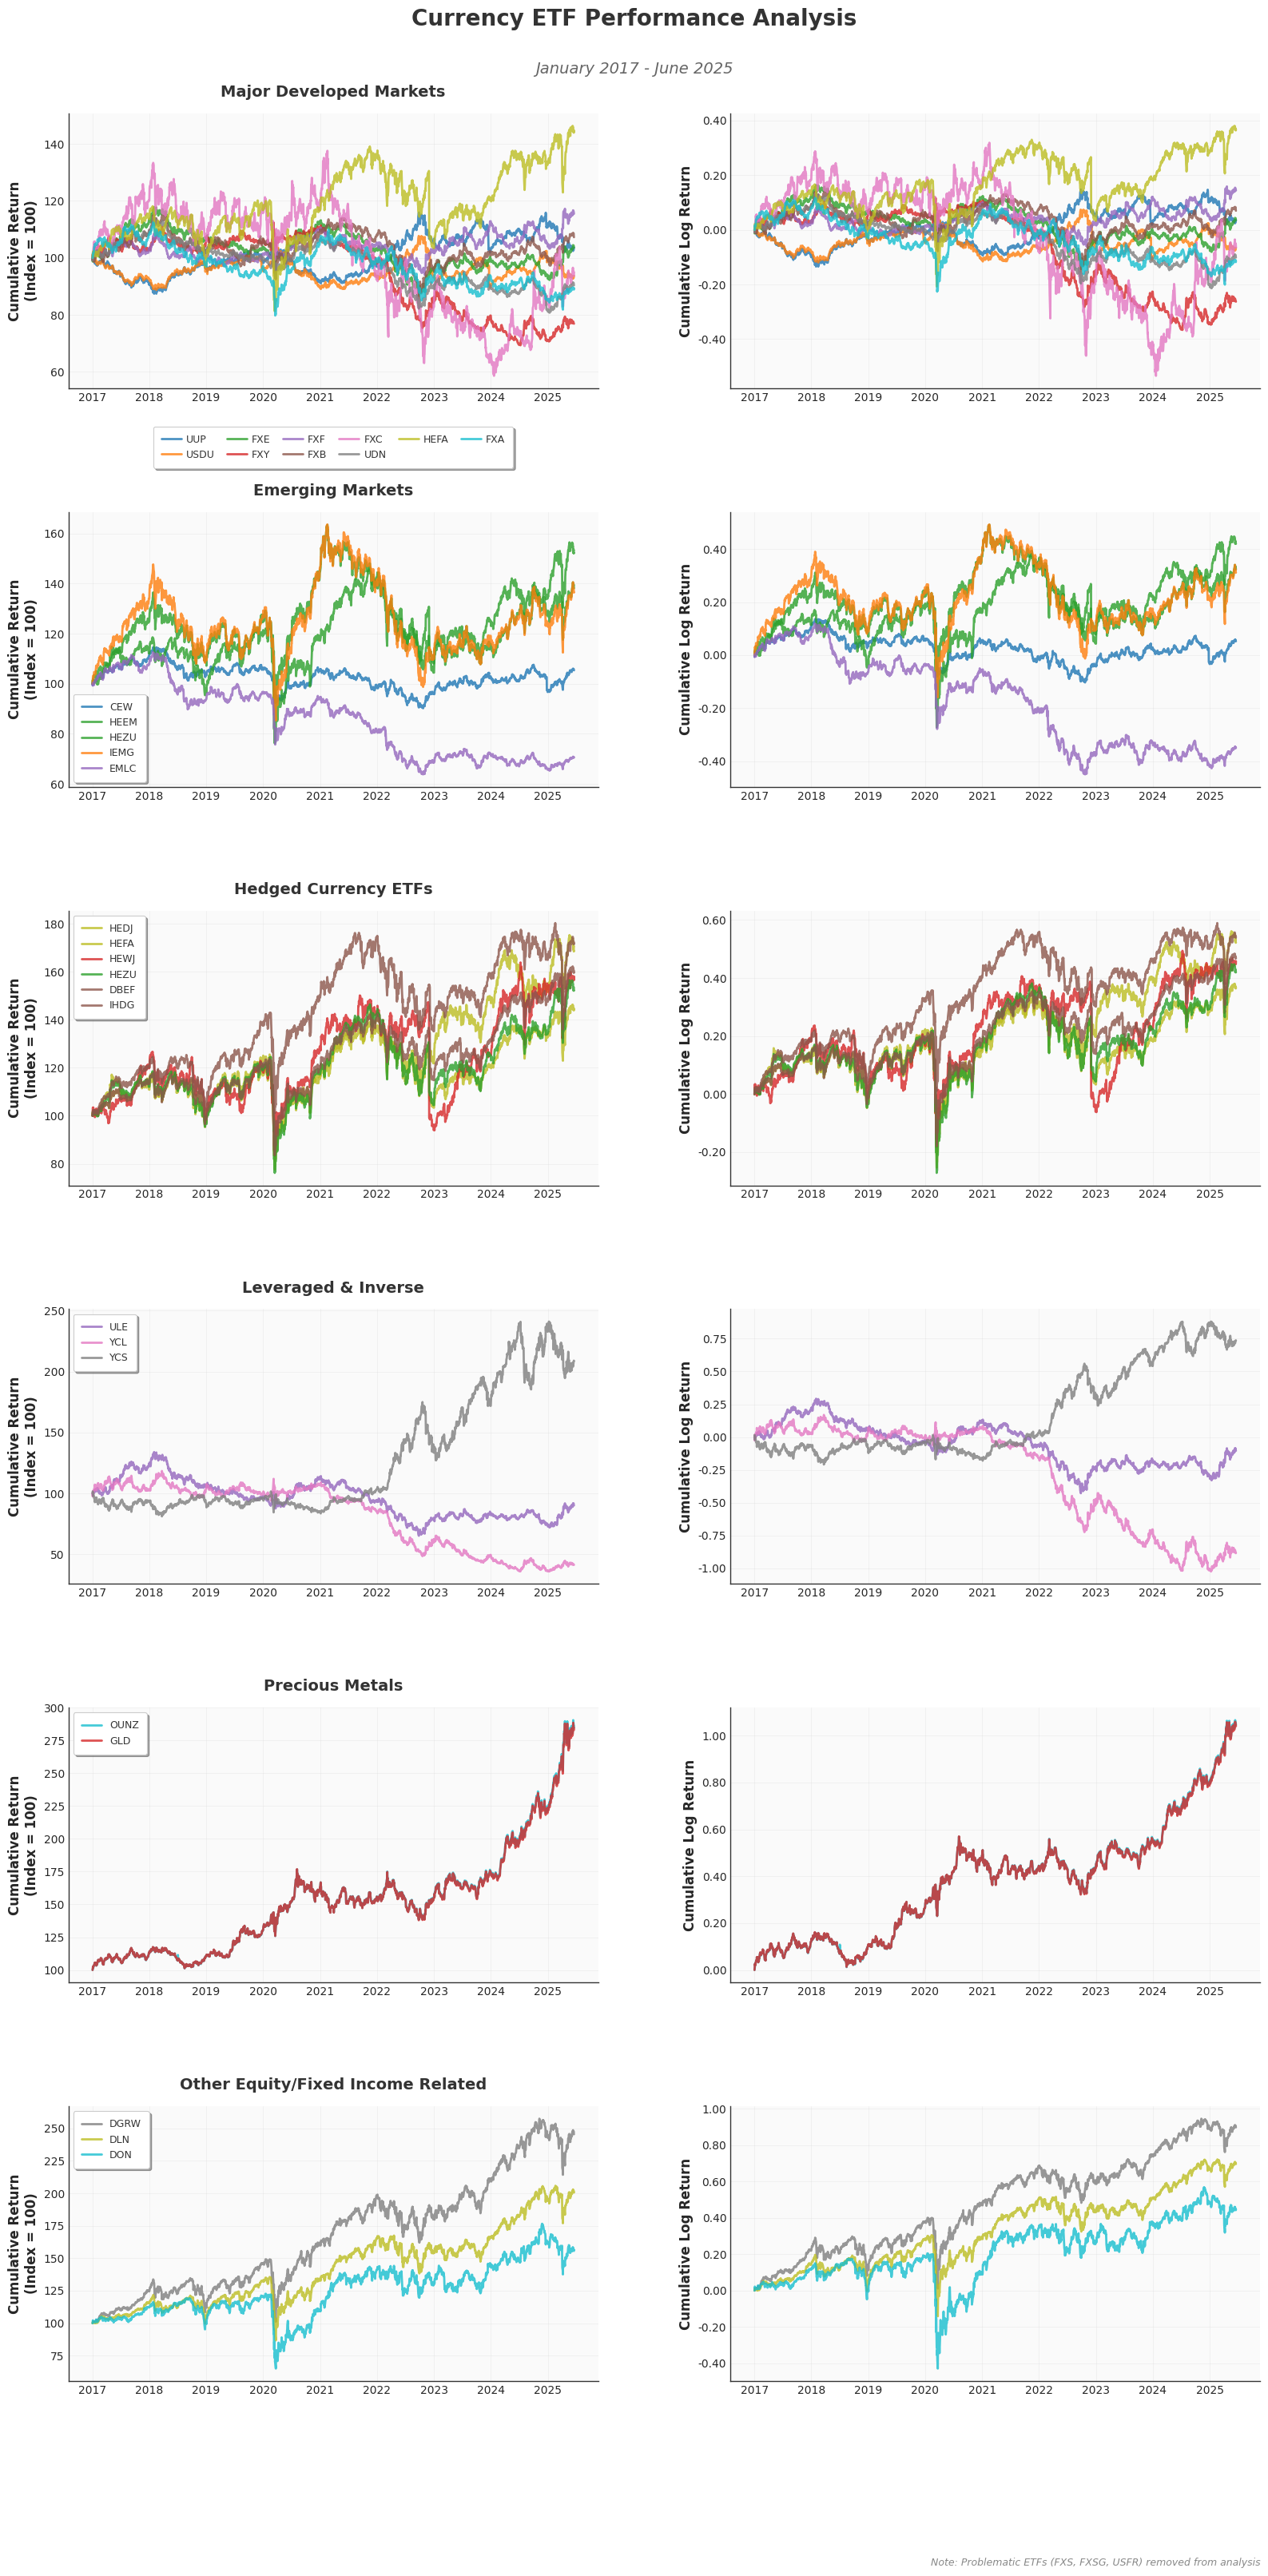


✅ Professional Analysis Complete:
📊 Total ETFs analyzed: 27
📅 Analysis period: 2017-01-02 to 2025-06-18
🗂️ Categories: 6

📋 Category Breakdown:
  • Major Developed Markets: 10 ETFs
  • Emerging Markets: 5 ETFs
  • Hedged Currency ETFs: 6 ETFs
  • Leveraged & Inverse: 3 ETFs
  • Precious Metals: 2 ETFs
  • Other Equity/Fixed Income Related: 3 ETFs

🗑️ Excluded ETFs:
  • FXS (Swedish Krona) - Delisted Feb 2020
  • FXSG (Singapore Dollar) - Delisted Feb 2020
  • USFR (Money Market) - Minimal volatility, not currency-focused


In [ ]:
# 🧹 Clean up the data by removing problematic ETFs

# ETFs to remove based on analysis
problematic_etfs = ['FXS', 'FXSG', 'USFR']  # Add any others you want to exclude

# Create cleaned dataset
etf_data_clean = {ticker: data for ticker, data in etf_data.items()
                  if ticker not in problematic_etfs}

print(f"🧹 Removed {len(problematic_etfs)} problematic ETFs: {problematic_etfs}")
print(f"📊 Clean dataset now has {len(etf_data_clean)} ETFs")

# Update categories to remove the problematic tickers
categories_clean = {}
for category_name, tickers in categories.items():
    clean_tickers = [t for t in tickers if t not in problematic_etfs]
    if clean_tickers:  # Only keep categories that still have tickers
        categories_clean[category_name] = clean_tickers

print("\n📋 Updated categories:")
for cat_name, tickers in categories_clean.items():
    print(f"  {cat_name}: {len(tickers)} ETFs - {tickers}")

# 🎨 Professional styling updates
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': [16, 20],
    'font.family': 'DejaVu Sans',  # Professional font
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 9,
    'figure.titlesize': 18,
    'axes.spines.top': False,      # Remove top spine
    'axes.spines.right': False,    # Remove right spine
    'axes.grid': True,
    'axes.axisbelow': True,
    'grid.alpha': 0.3,
    'lines.linewidth': 2.0,
    'axes.edgecolor': '#333333',
    'text.color': '#333333'
})

# 🖼️ Professional plot helper function
def plot_group_professional(ax_left, ax_right, group_name, tickers):
    for tic in tickers:
        df = etf_data_clean[tic]
        # Use slightly thicker lines for better visibility
        ax_left.plot(df['Date'], df['CumReturn'],
                     label=tic, color=ticker_colors[tic], linewidth=2.0, alpha=0.8)
        ax_right.plot(df['Date'], df['CumLogReturn'],
                      label=tic, color=ticker_colors[tic], linewidth=2.0, alpha=0.8)

    # Professional title formatting
    ax_left.set_title(group_name, fontweight='bold', pad=15, fontsize=14)
    ax_left.set_ylabel("Cumulative Return\n(Index = 100)", fontweight='bold')
    ax_right.set_ylabel("Cumulative Log Return", fontweight='bold')

    # Format x-axis
    ax_left.tick_params(axis='x', rotation=0)
    ax_right.tick_params(axis='x', rotation=0)

    # Professional legend positioning
    if len(tickers) > 8:
        ncols = min(6, len(tickers))
        legend = ax_left.legend(bbox_to_anchor=(0.5, -0.12), loc='upper center',
                               fontsize=9, ncol=ncols, frameon=True,
                               fancybox=True, shadow=True, borderpad=0.8,
                               columnspacing=1.2, handletextpad=0.5)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_edgecolor('#cccccc')
        legend.get_frame().set_linewidth(0.8)
    else:
        legend = ax_left.legend(loc='best', fontsize=9, frameon=True,
                               fancybox=True, shadow=True, borderpad=0.8)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_edgecolor('#cccccc')
        legend.get_frame().set_linewidth(0.8)

    # Professional grid styling
    ax_left.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax_right.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

    # Add subtle background color
    ax_left.set_facecolor('#fafafa')
    ax_right.set_facecolor('#fafafa')

    # Format y-axis to show percentage signs and better spacing
    ax_left.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))
    ax_right.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))

# 📈 Generate professional charts
n_groups_clean = len(categories_clean)
fig, axes = plt.subplots(n_groups_clean, 2, figsize=(16, 5.5 * n_groups_clean))

# Set professional figure background
fig.patch.set_facecolor('white')

if n_groups_clean == 1:
    axes = np.array([axes])

for idx, (name, tickers) in enumerate(categories_clean.items()):
    plot_group_professional(axes[idx, 0], axes[idx, 1], name, tickers)

# Professional title and subtitle
fig.suptitle("Currency ETF Performance Analysis",
             fontsize=20, fontweight='bold', y=0.98, color='#333333')

# Add subtitle with date range
fig.text(0.5, 0.955, "January 2017 - June 2025",
         ha='center', fontsize=14, color='#666666', style='italic')

# Add footer with data note
fig.text(0.99, 0.01, "Note: Problematic ETFs (FXS, FXSG, USFR) removed from analysis",
         ha='right', fontsize=9, color='#888888', style='italic')

# Professional spacing with extra vertical space to prevent legend overlap
plt.tight_layout()
plt.subplots_adjust(top=0.94, bottom=0.08, hspace=0.45, wspace=0.25)
plt.show()

# Summary statistics
print(f"\n✅ Professional Analysis Complete:")
print(f"📊 Total ETFs analyzed: {len(etf_data_clean)}")
print(f"📅 Analysis period: 2017-01-02 to 2025-06-18")
print(f"🗂️ Categories: {len(categories_clean)}")

# Show category breakdown
print(f"\n📋 Category Breakdown:")
for cat_name, tickers in categories_clean.items():
    print(f"  • {cat_name}: {len(tickers)} ETFs")

print(f"\n🗑️ Excluded ETFs:")
print(f"  • FXS (Swedish Krona) - Delisted Feb 2020")
print(f"  • FXSG (Singapore Dollar) - Delisted Feb 2020")
print(f"  • USFR (Money Market) - Minimal volatility, not currency-focused")